In [1]:
from src.config import config

In [2]:
from src.input_pipeline import create_dataloaders

train_loader, val_loader = create_dataloaders()

In [3]:
from src.models import MPCTransformer
model_config = config['model']

model = MPCTransformer(**model_config)

/home/jannik/miniconda3/lib/python3.10/site-packages/jax/_src/api_util.py:190: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [4]:
from src.train import train

num_epochs = 200

state, metrics_history = train(model, num_epochs, train_loader, val_loader)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Epoch: 0, Train Loss: 0.010256427340209484, Val Loss: 0.007189013995230198, 
Epoch: 1, Train Loss: 0.00733359856531024, Val Loss: 0.006120826117694378, 
Epoch: 2, Train Loss: 0.006483586970716715, Val Loss: 0.005539706442505121, 
Epoch: 3, Train Loss: 0.005919731687754393, Val Loss: 0.0051121157594025135, 
Epoch: 4, Train Loss: 0.005449692718684673, Val Loss: 0.00474164355546236, 
Epoch: 5, Train Loss: 0.005060799419879913, Val Loss: 0.004449883941560984, 
Epoch: 6, Train Loss: 0.0047559174709022045, Val Loss: 0.004238889552652836, 
Epoch: 7, Train Loss: 0.0045274291187524796, Val Loss: 0.004084271844476461, 
Epoch: 8, Train Loss: 0.004355897195637226, Val Loss: 0.003964680712670088, 
Epoch: 9, Train Loss: 0.004222136922180653, Val Loss: 0.003875764785334468, 
Epoch: 10, Train Loss: 0.004106292966753244, Val Loss: 0.0037726019509136677, 
Epoch: 11, Train Loss: 0.0037964547518640757, Val Loss: 0.002428269712254405, 
Epoch: 12, Train Loss: 0.0024360334500670433, Val Loss: 0.0019976992625

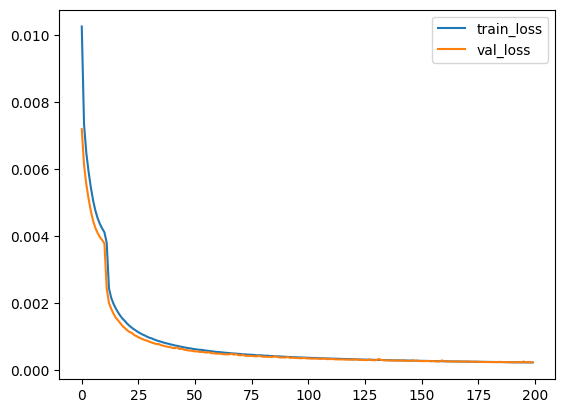

In [5]:
import matplotlib.pyplot as plt

plt.plot(metrics_history['train_loss'], label='train_loss')
plt.plot(metrics_history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [6]:
import torch
from src.input_pipeline import create_dataset
from tqdm import tqdm

dataset = create_dataset()

In [13]:
commands ={'target': [], 'pred': []}

for i in tqdm(range(len(dataset))):
  grid, u_target = dataset.__getitem__(i)
  grid = torch.unsqueeze(grid, 0).numpy()
  
  u_pred = model.apply({'params': state.params}, grid, train=False)
  
  commands['target'].append(u_target[0,0])
  commands['pred'].append(u_pred[0,0,0])

100%|██████████| 316/316 [13:44<00:00,  2.61s/it]


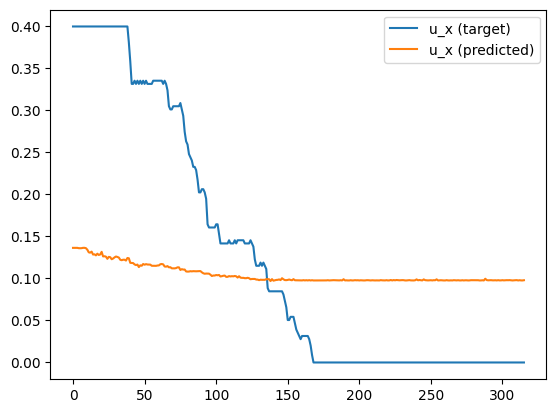

In [14]:
plt.plot(commands['target'], label='u_x (target)')
plt.plot(commands['pred'], label='u_x (predicted)')
plt.legend()
plt.show()

In [12]:
from flax.training import train_state, checkpoints
import jax

CKPT_DIR = '../checkpoints/'

checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=0)
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

assert jax.tree_util.tree_all(jax.tree_map(lambda x, y: (x == y).all(), state.params, restored_state.params))